<a href="https://colab.research.google.com/github/LailaMRomero/NeuralNetwork/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Segmentation of Urban UAV Footage**


## **Notebook Setup**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys

PROJECT = '/content/drive/MyDrive/COSC6338'
DATASET = '/content/drive/MyDrive/COSC6338/Dataset'
TOOLKIT = '/content/drive/MyDrive/COSC6338/Dataset/UAVidToolKit'
sys.path.append(PROJECT)

%cd $PROJECT

!pip install segmentation-models-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys

PROJECT = '/content/drive/MyDrive/COSC6338'
DATASET = '/content/drive/MyDrive/COSC6338/Dataset'
TOOLKIT = '/content/drive/MyDrive/COSC6338/Dataset/UAVidToolKit'
sys.path.append(PROJECT)

%cd $PROJECT

!pip install segmentation-models-pytorch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/COSC6338


In [ ]:
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as tf
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
from tqdm import tqdm
import torch.nn as nn
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
import logging
import shutil
import torch
import errno
import cv2
import os
import re

In [ ]:
#Setting up the dataset tools in order to work with the dataset.

%cd $TOOLKIT
!python3 setup.py build_ext --inplace
%cd $PROJECT

/content/drive/MyDrive/COSC6338/Dataset/UAVidToolKit
running build_ext
/content/drive/MyDrive/COSC6338


## **Global Parameters for Model**

### Setup of paths for the data subdirectories

In [ ]:
#### DATA FILEPATH SETUP #####
TRAIN_DATA = os.path.join(DATASET, 'train')
if not os.path.exists(TRAIN_DATA):
  print('PATH: {} does not exists'.format(TRAIN_DATA))

VAL_DATA = os.path.join(DATASET, 'valid')
if not os.path.exists(VAL_DATA):
  print('PATH: {} does not exists'.format(VAL_DATA))

TEST_DATA = os.path.join(DATASET, 'test')
if not os.path.exists(TEST_DATA):
  print('PATH: {} does not exists'.format(TEST_DATA))

### Data loading and preprocessing global variables

In [ ]:
##### DATA PREPROCESSING GLOBALS #####
remove_videos = False 
find_data_filepaths = False
resize_images_masks = False
split_into_chips = False
save_fp_to_csv = False
load_from_csv = True

RESIZED_IMAGE_HEIGHT = 1024
RESIZED_IMAGE_WIDTH = 2048
TARGET_CHIP_SIZE = 256



### Model training options

In [ ]:
##### MODEL TRAINING OPTIONS #####
model1 = True

save_model = True
load_model_to_train = False
load_model_to_eval = True

## **Data Preprocessing**


### Remove superfluous data i.e. videos from dataset

In [ ]:
#If videos are in the original dataset, then they need to be moved.
#Set setup_dataset_directories to True and execute this cell to move the videos.
#This cell only needs to be run once.

if remove_videos:
  for child in os.scandir(DATASET):
    if child.is_dir():
        for grandchild in os.scandir(child.path):
            os.makedirs(re.sub(r'Dataset/', r'Videos/', grandchild.path))
            shutil.move(os.path.join(grandchild.path, 'images.mp4'), os.path.join(re.sub(r'Dataset/', r'Videos/', grandchild.path), 'images.mp4') )

### Creating masks from the labels
  - No need to run unless the masks are not created

In [ ]:
!python3 ./Dataset/UAVidToolKit/prepareTrainIdFiles.py -s ./Dataset/train -t ./Dataset/train_masks

python3: can't open file './Dataset/UAVidToolKit/prepareTrainIdFiles.py': [Errno 2] No such file or directory


In [ ]:
num = 0
for dir, sub, files in os.walk(os.path.join(DATASET, 'train_masks')):
  num += len(files)
  print("Files in", dir, len(files))

print(num)

Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq13 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq13/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq14 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq14/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq7 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq7/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq3 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq3/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq1 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq1/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq8 0
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/seq8/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/train_masks/se

In [ ]:
!python3 ./Dataset/UAVidToolKit/prepareTrainIdFiles.py -s ./Dataset/valid -t ./Dataset/valid_masks

python3: can't open file './Dataset/UAVidToolKit/prepareTrainIdFiles.py': [Errno 2] No such file or directory


In [ ]:
num = 0
for dir, sub, files in os.walk(os.path.join(DATASET, 'valid_masks')):
  num += len(files)
  print("Files in", dir, len(files))

print(num)

Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq36 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq36/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq19 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq19/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq16 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq16/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq20 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq20/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq18 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq18/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq37 0
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_masks/seq37/TrainId 10
Files in /content/drive/MyDrive/COSC6338/Dataset/valid_

### Determining the filepaths of the images and their masks

In [ ]:
def find_images_masks_paths(dir_path, old_path, mask_path, image_list, mask_list):
  for child in os.scandir(dir_path):
    image_dir = os.path.join(child.path, 'Images')
    mask_dir = re.sub(old_path, mask_path, child.path)
    mask_dir = os.path.join(mask_dir, 'TrainId')

    image_list.extend(glob(os.path.join(image_dir, '*.png')))
    mask_list.extend(glob(os.path.join(mask_dir, '*.png')))

if find_data_filepaths:

  images, masks = [], []

  find_images_masks_paths(TRAIN_DATA, 'train/', 'train_masks/', images, masks)
  find_images_masks_paths(VAL_DATA, 'valid/', 'valid_masks/', images, masks)

  images.sort()
  masks.sort()

  filepath_df = pd.DataFrame(list(zip(images, masks)), columns=['Images', 'Masks'])

  filepath_df

### Resizing Images and Masks so that all are a consistent size

In [ ]:
if resize_images_masks:

  RESIZED_IMAGE_DIR = os.path.join(DATASET, 'Resized_Imgs')
  RESIZED_MASKS_DIR = os.path.join(DATASET, 'Resized_Masks')

  if not os.path.exists(RESIZED_IMAGE_DIR):
    os.mkdir(RESIZED_IMAGE_DIR)

  if not os.path.exists(RESIZED_MASKS_DIR):
    os.mkdir(RESIZED_MASKS_DIR)

  for item in tqdm(filepath_df.itertuples()):
    filename = os.path.basename(item[1])
    seq = re.search(r'(seq[0-9]*)', item[1])[0]

    assert filename == os.path.basename(item[2]) and seq == re.search(r'(seq[0-9]*)', item[2])[0], "The image path and mask path differ"

    image = cv2.imread(item[1])
    mask = cv2.imread(item[2], cv2.IMREAD_UNCHANGED)

    image = cv2.resize(image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT), cv2.INTER_AREA)
    mask = cv2.resize(mask, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT), cv2.INTER_NEAREST)
  
    cv2.imwrite(os.path.join(RESIZED_IMAGE_DIR, '{}_{}'.format(seq, filename)), image)
    cv2.imwrite(os.path.join(RESIZED_MASKS_DIR, '{}_{}'.format(seq, filename)), mask)



### Function to load image filepaths and mask filepaths into dataframes

In [ ]:
def load_dataframe(img_dir, mask_dir):
  img_paths = glob(os.path.join(img_dir, '*.png'))
  mask_paths = glob(os.path.join(mask_dir, '*.png'))

  img_paths.sort()
  mask_paths.sort()

  filepath_df = pd.DataFrame(list(zip(img_paths, mask_paths)), columns=['Images', 'Masks'])

  return filepath_df

### Splitting the Images and Masks into Chips

In [ ]:
if split_into_chips:

  IMGS_DIR = os.path.join(DATASET, 'Resized_Imgs')
  MASKS_DIR = os.path.join(DATASET, 'Resized_Masks')

  filepath_df = load_dataframe(IMGS_DIR, MASKS_DIR)
  
  print(filepath_df)

In [ ]:
IMG_CHIPS_DIR = os.path.join(DATASET, 'Img_Chips')
MASKS_CHIPS_DIR = os.path.join(DATASET, 'Masks_Chips')

if split_into_chips:

  if not os.path.exists(IMG_CHIPS_DIR):
    os.mkdir(IMG_CHIPS_DIR)

  if not os.path.exists(MASKS_CHIPS_DIR):
    os.mkdir(MASKS_CHIPS_DIR)

  for item in tqdm(filepath_df.itertuples()):
    img_filename = os.path.splitext(os.path.basename(item[1]))[0]
    mask_filename = os.path.splitext(os.path.basename(item[2]))[0]

    img = cv2.imread(item[1])
    mask = cv2.imread(item[2], cv2.IMREAD_UNCHANGED)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2], "Either the Image's filename != the Mask's filename or the Image's dim != the Mask's dim."

    chip_num = 0
    for y in range(0, img.shape[0], TARGET_CHIP_SIZE):
      for x in range(0, img.shape[1], TARGET_CHIP_SIZE):
        img_chip = img[y:y + TARGET_CHIP_SIZE, x:x + TARGET_CHIP_SIZE]
        mask_chip = mask[y:y + TARGET_CHIP_SIZE, x:x + TARGET_CHIP_SIZE]

        if img_chip.shape[0] == TARGET_CHIP_SIZE and img_chip.shape[1] == TARGET_CHIP_SIZE:
          out_img_chip_path = os.path.join(IMG_CHIPS_DIR, "{}_{}.png".format(img_filename, chip_num))
          cv2.imwrite(out_img_chip_path, img_chip)

          out_img_chip_path = os.path.join(MASKS_CHIPS_DIR, "{}_{}.png".format(mask_filename, chip_num))
          cv2.imwrite(out_img_chip_path, mask_chip)
        chip_num +=1

if save_fp_to_csv:
  chips_df = load_dataframe(IMG_CHIPS_DIR, MASKS_CHIPS_DIR)
  chips_df.to_csv(os.path.join(DATASET, "chips.csv"))

## **UNET Model**

### Custom Dataclass Definition

In [ ]:
class UAVidDataset(Dataset):
  
  def __init__(self, df, transform=None):
    self.df = df

    assert self.df.shape[1] == 2, 'The dataframe should only contain two columns: Images and Masks'

    self.transform = transform
  
  def __getitem__(self, index):
    image_file = self.df.iloc[index, 0]
    mask_file = self.df.iloc[index, 1]

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_file, cv2.IMREAD_UNCHANGED)
    image = image.astype('uint8')

    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image = transformed["image"]
      mask = transformed["mask"]

      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)

      image = image.permute(2, 0, 1)
      image = image.float()/255

      mask = mask.long().unsqueeze(0)
    else:
      image = torch.from_numpy(image)
      mask = torch.from_numpy(mask)

      image = image.permute(2, 0, 1)
      image = image.float()/255

      mask = mask.long().unsqueeze(0)
    
    return image, mask
  
  def __len__(self):
    return len(self.df)

### Model Definition

In [ ]:
class UNET(nn.Module):

    def __init__(self, in_channels=3, classes=8, layer_channels=[64, 128, 256, 512, 1024]):
        super(UNET, self).__init__()

        layer_channels.insert(0, in_channels)

        self.layers = layer_channels

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
            [self.__double_conv(layer, layer // 2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), # added for precision
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []

        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)

        concat_layers = concat_layers[::-1]

        # up layers
        for up_trans, double_conv_up, concat_layer in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = tf.resize(x, concat_layer.shape[2:])

            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)

        x = self.final_conv(x)

        return x

    @torch.no_grad()
    def predict(self, x):
      x = self.forward(x)
      return x


## **Data Loading**

### Data Loading Options

In [ ]:
#Data Loading Options
seed = 42
test_data_size = 0.1
shuffle_data = True
batch_size = 16

### Load Chip Filepaths fro CSV

In [ ]:
chips_df = None
if load_from_csv:
  chips_df = pd.read_csv(os.path.join(DATASET, "chips.csv"))
  chips_df.drop(["Unnamed: 0"], inplace=True, axis=1)
else:
  chips_df = load_dataframe(IMG_CHIPS_DIR, MASKS_CHIPS_DIR)

assert chips_df is not None, 'Chips_df must be created first and loaded with the filepaths of the images and masks'
chips_df

,Images,Masks
0,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
1,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
2,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
3,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
4,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
...,...,...
8635,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
8636,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
8637,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
8638,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...


### Split Dataset into Train, Valid, Test sets

In [ ]:
train_df, test_df = train_test_split(chips_df, test_size=test_data_size, random_state=seed, shuffle=shuffle_data)

train_df, val_df = train_test_split(train_df, test_size=test_data_size, random_state=seed, shuffle=shuffle_data)

train_df

,Images,Masks
2881,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
6353,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
1966,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
1696,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
8610,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
...,...,...
3883,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
2390,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
491,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
2327,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...


In [ ]:
val_df

,Images,Masks
6792,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
3286,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
6727,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
5827,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
3903,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
...,...,...
5655,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
6554,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
3270,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
2949,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...


In [ ]:
test_df

,Images,Masks
6805,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
4570,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
222,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
3984,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
318,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
...,...,...
7913,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
7452,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
7161,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...
1729,/content/drive/MyDrive/COSC6338/Dataset/Img_Ch...,/content/drive/MyDrive/COSC6338/Dataset/Masks_...


### Creating transforms

In [ ]:
plain_transform = A.Compose( [A.PadIfNeeded(min_height=TARGET_CHIP_SIZE, min_width=TARGET_CHIP_SIZE, border_mode=4)] )

model1_transform = A.Compose( [A.PadIfNeeded(min_height=TARGET_CHIP_SIZE, min_width=TARGET_CHIP_SIZE, border_mode=4),
                              A.Resize(TARGET_CHIP_SIZE, TARGET_CHIP_SIZE, interpolation=cv2.INTER_NEAREST),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5), 
                              A.HorizontalFlip(p=0.5),
                              A.VerticalFlip(p=0.5),
                              A.MedianBlur(blur_limit=3, always_apply=False, p=0.1)] )

### Creating UAVidDataset Instances

In [ ]:
if model1:
  trainDS = UAVidDataset(train_df, transform=model1_transform)
  PATH = './Models/model1.pth'
  HIST_PATH = './Models/model1_training_hist.csv'
else:
  trainDS = UAVidDataset(train_df, transform=plain_transform)
  PATH = './Models/model_plain.pth'
  HIST_PATH = './Models/model_plain_training_hist.csv'

valDS = UAVidDataset(val_df, transform=plain_transform)
testDS = UAVidDataset(test_df, transform=plain_transform)

### Creating the DataLoaders

In [ ]:
trainDL = DataLoader(trainDS, batch_size=batch_size,
                     shuffle=False, sampler=None,
                     batch_sampler=None, num_workers=0,
                     collate_fn=None, pin_memory=False,
                     drop_last=False, timeout=0, worker_init_fn=None)

valDL = DataLoader(valDS, batch_size=batch_size,
                    shuffle=False, sampler=None,
                    batch_sampler=None, num_workers=0,
                    collate_fn=None, pin_memory=False,
                    drop_last=False, timeout=0, worker_init_fn=None)

testDL = DataLoader(testDS, batch_size=batch_size,
                    shuffle=False, sampler=None,
                    batch_sampler=None, num_workers=0,
                    collate_fn=None, pin_memory=False,
                    drop_last=False, timeout=0, worker_init_fn=None)

In [ ]:
sample_batch = next(iter(trainDL)) 
images, masks = sample_batch

print("Image Batch Shape: {}. Image Batch Type: {}. Image DataType: {}.".format(images.shape, type(images), images.dtype))
print("Mask Batch Shape: {}. Mask Batch Type: {}. Mask DataType: {}.".format(masks.shape, type(masks), masks.dtype))

Image Batch Shape: torch.Size([16, 3, 256, 256]). Image Batch Type: <class 'torch.Tensor'>. Image DataType: torch.float32.
Mask Batch Shape: torch.Size([16, 1, 256, 256]). Mask Batch Type: <class 'torch.Tensor'>. Mask DataType: torch.int64.


In [ ]:
image_val = images[4]
mask_val = masks[4]

print("Validation of Image Shape: {}. Validation of Image Data Type: {}. Validation of Image Type: {}".format(image_val.shape, image_val.dtype, type(image_val)))
print("Validtion of Image Minimum Value: {}. Validation of Image Maximum Value: {}\n".format(image_val.min(), image_val.max()))

print("Validation of Mask Shape: {}. Validation of Image Mask Type: {}. Validation of Mask Type: {}".format(mask_val.shape, mask_val.dtype, type(mask_val)))
print("Validtion of Mask Minimum Value: {}. Validation of Mask Maximum Value: {}".format(mask_val.min(), mask_val.max()))

Validation of Image Shape: torch.Size([3, 256, 256]). Validation of Image Data Type: torch.float32. Validation of Image Type: <class 'torch.Tensor'>
Validtion of Image Minimum Value: 0.0. Validation of Image Maximum Value: 1.0

Validation of Mask Shape: torch.Size([1, 256, 256]). Validation of Image Mask Type: torch.int64. Validation of Mask Type: <class 'torch.Tensor'>
Validtion of Mask Minimum Value: 0. Validation of Mask Maximum Value: 5


## **Model Training**

### Model Hyperparameters and Data Parameters

In [ ]:
#Data Parameters
input_channels = 3
num_classes = 8
classes = []

#Model HyperParamters
learning_rate = 0.0005
epochs = 30
layers_output_ch = [64, 128, 256, 512]

### Train

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

Running on the GPU


In [ ]:
model = UNET(in_channels=input_channels, classes=num_classes, layer_channels=layers_output_ch)

x = torch.randn(size=(1, 3, 256, 256), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([1, 8, 256, 256])


In [ ]:
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,728
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
             ReLU-11        [-1, 128, 128, 128]               0
        MaxPool2d-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         294,912
      BatchNorm2d-14          [-1, 256,

In [ ]:
#setting up necessary functions and objects for training
loss_function = smp.losses.DiceLoss(mode='multiclass')
loss_function.__name__ = 'Dice_loss'

IoU_Loss = smp.losses.JaccardLoss(mode='multiclass')
IoU_Loss.__name__ = 'Jaccard_loss'

metx = [IoU_Loss]

opt = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
training_loss_hist = []
validation_loss_hist = []

training_IoULoss_hist = []
validation_IoULoss_hist = []

if load_model_to_train:
  model.load_state_dict(torch.load(PATH)['model_state_dict'])
  opt.load_state_dict(torch.load(PATH)['optimizer_state_dict'])

training_epoch = smp.utils.train.TrainEpoch(model=model, 
                                            loss=loss_function, 
                                            metrics=metx, 
                                            optimizer=opt, 
                                            device=DEVICE)

validating_epoch = smp.utils.train.ValidEpoch(model=model, 
                                            loss=loss_function, 
                                            metrics=metx, 
                                            device=DEVICE)

for e in range(epochs):
  training_logs = training_epoch.run(trainDL)
  validation_logs = validating_epoch.run(valDL)

  training_loss_hist.append(training_logs['Dice_loss'])
  validation_loss_hist.append(validation_logs['Dice_loss'])

  training_IoULoss_hist.append(training_logs['Jaccard_loss'])
  validation_IoULoss_hist.append(validation_logs['Jaccard_loss'])
    
  if save_model:
    if model1:
      torch.save({
        'model_state_dict': training_epoch.model.state_dict(),
        'optimizer_state_dict': training_epoch.optimizer.state_dict(),
        'epoch': epochs}, PATH)

valid: 100%|██████████| 49/49 [00:15<00:00,  3.12it/s, Dice_loss - 0.4028, Jaccard_loss - 0.5348]


In [ ]:
training_hist = pd.DataFrame(list(zip(training_loss_hist, validation_loss_hist, training_IoULoss_hist, validation_IoULoss_hist)), 
                             columns=['Train_Dice', 'Val_Dice', 'Train_IoU', 'Val_IoU'])

training_hist.to_csv(HIST_PATH)

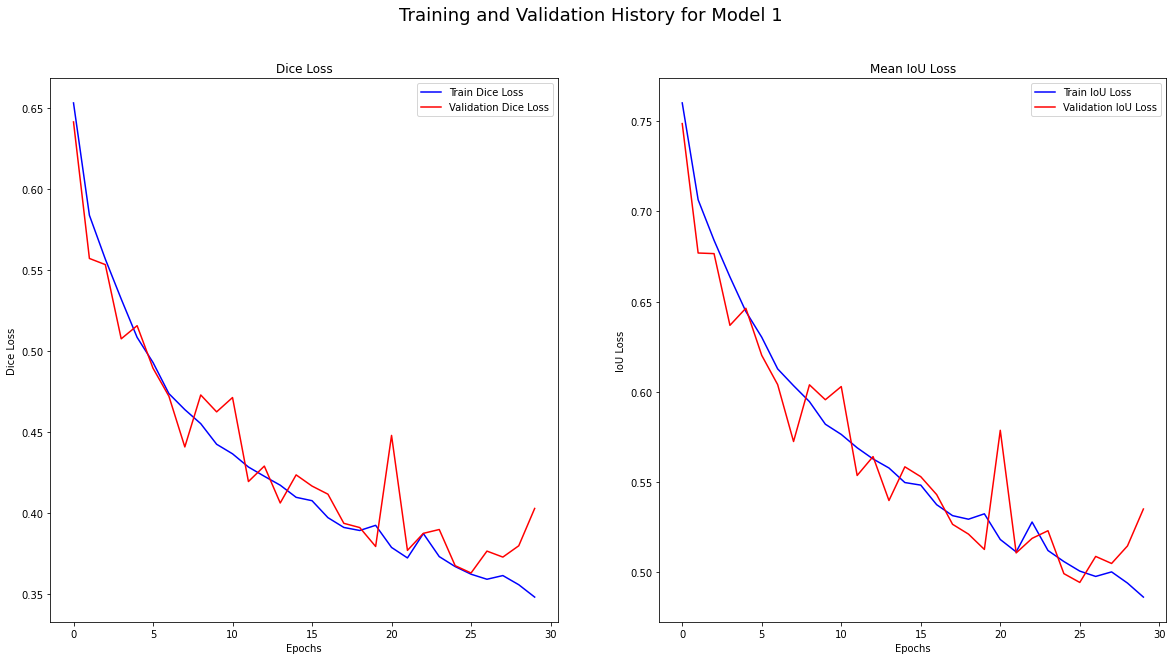

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle('Training and Validation History for Model 1', size=18)

ax[0].title.set_text('Dice Loss')
ax[0].set_ylabel("Dice Loss")
ax[0].set_xlabel("Epochs")
ax[0].plot(training_hist.index, training_hist['Train_Dice'], color='blue', label='Train Dice Loss')
ax[0].plot(training_hist.index, training_hist['Val_Dice'], color='red', label='Validation Dice Loss')
ax[0].legend()

ax[1].title.set_text('Mean IoU Loss')
ax[1].set_ylabel("IoU Loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(training_hist.index, training_hist['Train_IoU'], color='blue', label='Train IoU Loss')
ax[1].plot(training_hist.index, training_hist['Val_IoU'], color='red', label='Validation IoU Loss')
ax[1].legend()

plt.savefig('./Models/training_hist_plot.png')

## **Model Evaluation**

### Evaluation Setup

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

Running on the GPU


In [ ]:
#To load a saved model to evaluate
if load_model_to_eval:
  model = UNET(in_channels=input_channels, classes=num_classes, layer_channels=layers_output_ch)
  if DEVICE == 'cpu':
    model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu'))['model_state_dict'])
  else:
    model.load_state_dict(torch.load(PATH)['model_state_dict'])

  loss_function = smp.losses.DiceLoss(mode='multiclass')
  loss_function.__name__ = 'Dice_loss'

  IoU_Loss = smp.losses.JaccardLoss(mode='multiclass')
  IoU_Loss.__name__ = 'Jaccard_loss'

  metx = [IoU_Loss]

testing_epoch = smp.utils.train.ValidEpoch(model=model, 
                                            loss=loss_function, 
                                            metrics=metx, 
                                            device=DEVICE)

### Evaluating Model's Performance on Test Dataset

In [ ]:
# Determining the Model's Dice Loss and Jaccard Loss performance on the test dataset
evaluation_criteria = testing_epoch.run(testDL)
print("Model's Dice Loss: {}. Model's Jaccard Loss: {}.".format(evaluation_criteria['Dice_loss'], evaluation_criteria['Jaccard_loss']))

valid: 100%|██████████| 54/54 [00:18<00:00,  2.87it/s, Dice_loss - 0.3959, Jaccard_loss - 0.5333]
Model's Dice Loss: 0.3958858417140113. Model's Jaccard Loss: 0.5333351746753412.


### Predicting masks on test dataset

In [ ]:
PRED_DIR = os.path.join(DATASET, 'Predictions')

if not os.path.exists(PRED_DIR):
  os.mkdir(PRED_DIR)

GT_DIR = os.path.join(PRED_DIR, 'GT_Masks')

if not os.path.exists(GT_DIR):
  os.mkdir(GT_DIR)

PR_DIR = os.path.join(PRED_DIR, 'PR_Masks')

if not os.path.exists(PR_DIR):
  os.mkdir(PR_DIR)

for i in tqdm(range(len(testDS))):
  name = os.path.splitext(os.path.basename(testDS.df.iloc[i,0]))[0]
  parts = name.split('_')
  
  image, gt_mask = testDS[i]

  gt_mask = gt_mask.squeeze().cpu().numpy()
  x_tensor = image.to(DEVICE).unsqueeze(0)

  pr_mask = model.predict(x_tensor)
  m = nn.Softmax(dim=1)

  pr_prob = m(pr_mask)
  pr_mask = torch.argmax(pr_prob, dim=1).squeeze(1)
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())

  filename = "{}_{}.png".format(parts[1], parts[2])

  gt_target = os.path.join(GT_DIR, parts[0], 'TrainId')
  if not os.path.exists(gt_target):
    os.makedirs(gt_target)
  pr_target = os.path.join(PR_DIR, parts[0], 'TrainId')
  if not os.path.exists(pr_target):
    os.makedirs(pr_target)

  cv2.imwrite(os.path.join(pr_target, filename), pr_mask)
  cv2.imwrite(os.path.join(gt_target, filename), gt_mask)

100%|██████████| 864/864 [00:27<00:00, 31.62it/s]


In [ ]:
!python3 ./Dataset/UAVidToolKit/convertTrainIdFiles2Color.py -s ./Dataset/Predictions/PR_Masks -t ./Dataset/Predictions/PR_Masks -f 'Labels'

100% 27/27 [00:09<00:00,  2.76it/s]


In [ ]:
!python3 ./Dataset/UAVidToolKit/convertTrainIdFiles2Color.py -s ./Dataset/Predictions/GT_Masks -t ./Dataset/Predictions/GT_Masks -f 'Labels'

100% 27/27 [00:09<00:00,  2.84it/s]


In [ ]:
!python3 ./Dataset/UAVidToolKit/evaluate.py -gt ./Dataset/Predictions/GT_Masks -p ./Dataset/Predictions/PR_Masks -v

CSUPPORT: True
This is a fast C++ way evaluation.
100% 864/864 [00:05<00:00, 171.56it/s]
IOUs: {'Clutter': 0.44621189674132017, 'Building': 0.7446012544436614, 'Road': 0.41201886517247166, 'Static_Car': 0.35727483503560375, 'Tree': 0.6592223394892675, 'Vegetation': 0.4803800844302937, 'Human': 0.33778059780837894, 'Moving_Car': 0.46829342682458097}
mIOU: 0.48822291249319727
acc: 0.7328254735028302
./Dataset/UAVidToolKit/evaluate.py:120: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
<Figure size 1400x500 with 1 Axes>
Normalized confusion matrix
<Figure size 800x600 with 2 Axes>
